In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from random import choice



%matplotlib inline

dpf=pd.read_csv('all_data.csv')
df=dpf.copy()

list_df=[]

for i in range(1,31):
    list_df.append(df[df["group"]==i])


# Data preprocese and the computation of the regresssion 

In [124]:
def preprocess(df):        
        tetha=0.9
        output_choice=[]
        output_features =[]
        R1_tetha=[]
        R2_tetha=[]
        for j in df.index:
                if (df["period"][j]==1):

                        value_static=df["r1"][j] + df["r2"][j] +df["risk"][j] +tetha +df["error"][j] +df["r1"][j]*tetha + df["r2"][j]*tetha+df["infin"][j]+df["contin"][j]
                        output_features.append(value_static)

                        if j <=len(df)-1:
                                output_choice.append(df["other.decision1"][j+1])
                        else:
                                output_choice.append("NAN")
                        R1_tetha.append(df["r1"][j]*tetha )
                        R2_tetha.append(df["r2"][j]*tetha )


                else:
                        value_dynamic= df["r1"][j] + df["r2"][j] +tetha +df["error"][j] +df["r1"][j]*tetha + df["r2"][j]*tetha+df["infin"][j]+df["contin"][j]+tetha*df["infin"][j]+df["period"][j] +  df["my.decision1"][j] +df["other.decision1"][j]+df["other.decision1"][j]*df["error"][j]
                        
                        output_features.append(value_dynamic)
                        R1_tetha.append(df["r1"][j]*tetha )
                        R2_tetha.append(df["r2"][j]*tetha )

                        if(df["period"][j]!=10 and j <len(df)-1):
                                output_choice.append(df["other.decision1"][j+1])
                        else:
                                output_choice.append("NAN")
                        
                


        pay_off_me=[]
        pay_off_other=[]

        for i in df.index:
                if(df["period"][i]!=10 and j <len(df)-1):        
                        pay_off_me.append(df["my.payoff1"][i+1])
                        pay_off_other.append(df["other.payoff1"][i+1])

                else:
                        pay_off_me.append("NAN")
                        pay_off_other.append("NAN")
        my_decision=[]

        for k in df.index:

                if df["my.decision"][k] == "coop":
                        my_decision.append(1)
                else:
                        my_decision.append(0)


                
        df["mydecision"]=my_decision
        df["mypayoff"]=pay_off_me
        df["otherpayoff"]=pay_off_other

        df['y(t)']=output_features
        df["Y_train"]=output_choice
        df["R1_tetha"]=R1_tetha
        df["R2_tetha"]=R2_tetha

        df.insert(1, 'tetha', 0.9)
        df.dropna(subset=["Y_train"], inplace=True)
        df["Y_train"].replace('', np.nan, inplace=True)

        indexNames = df[ df['Y_train'] == 'NAN' ].index
        # Delete these row indexes from dataFrame
        df.drop(indexNames , inplace=True)

        df["tetha*infin"] = df.infin*df.tetha 


        df["other.decision1*error"]=df["other.decision1"]*df.error

        for i in df.index:
                if (df["period"][i]==1) :

                        df["other.decision1*error"][i]=(df["Y_train"][i]).copy()
                        df["other.decision1"][i]=(df["Y_train"][i]).copy()
                        df["my.decision1"][i] = (df["Y_train"][i]).copy()
                        
        return df



<ipython-input-124-3901f06e32dc>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["other.decision1*error"][i]=(df["Y_train"][i]).copy()
<ipython-input-124-3901f06e32dc>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["other.decision1"][i]=(df["Y_train"][i]).copy()
<ipython-input-124-3901f06e32dc>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["my.decision1"][i] = (df["Y_train"][i]).copy()


Accuracy: 0.8646977342435935
Precision: 0.9108589951377634
Recall: 0.8001627173802501
classification report: 
               precision    recall  f1-score   support

         0.0       0.83      0.93      0.88     20762
         1.0       0.91      0.80      0.85     19666

    accuracy                           0.86     40428
   macro avg       0.87      0.86      0.86     40428
weighted avg       0.87      0.86      0.86     40428



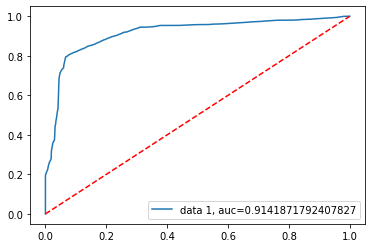

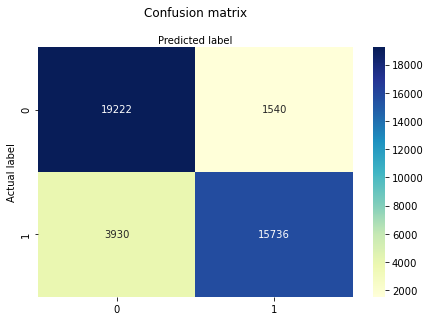

In [125]:
if __name__ == "__main__":

    preprocess(df)

    #static model  

    z=df[["r1","r2","risk","error","infin","contin","R2_tetha","R1_tetha"]]


    #dynamic models 
    X= df[["r1","r2","risk","error","infin","contin","R2_tetha","R1_tetha","tetha*infin","period","my.decision1" ,"other.decision1","other.decision1*error"]]
    #full models
    W=df[['y(t)']]

    Y=list(df["Y_train"])

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=0)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
   
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("classification report: \n",metrics.classification_report(y_test, y_pred))

    y_pred_proba = logreg.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc=4)
    
    plt.show()



    confusion_matrix = confusion_matrix(y_test, y_pred)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.savefig("Confusion_matrix_{fname}.png".format(fname ="Full"))
    plt.show()


#### True negatives in the upper-left position
#### False negatives in the lower-left position
#### False positives in the upper-right position
#### True positives in the lower-right position

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score



z=df[["r1","r2","risk","error","infin","contin","R2_tetha","R1_tetha"]]
X= df[["r1","r2","risk","error","infin","contin","R2_tetha","R1_tetha","tetha*infin","period","my.decision1" ,"other.decision1","other.decision1*error"]]
W=df[["y(t)"]]
Y=list(df["Y_train"])

X_train, X_test, y_train, y_test1 = train_test_split(z, Y, test_size=0.8, random_state=0)


rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=50,
                      max_features='auto')

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_classifier.fit(X_train,y_train)

y_pred1=rf_classifier.predict(X_test)

rf_classifier.feature_importances_

#plt.barh(X.columns, rf_classifier.feature_importances_)
#plt.savefig("Features importance_{fname}.png".format(fname ="Dynamic"))


y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test1,  y_pred_proba)
auc = metrics.roc_auc_score(y_test1, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc=4)
plt.savefig("ROC_{fname}.png".format(fname ="Dynamic"))
plt.show()



confusion_matrix = confusion_matrix(y_test1, y_pred1)

class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.savefig("Confusion_matrix_{fname}.png".format(fname ="Dynamic"))
plt.show()



"""
print("Accuracy:",metrics.accuracy_score(y_test1, y_pred1))
print("Precision:",metrics.precision_score(y_test1, y_pred1))
print("Recall:",metrics.recall_score(y_test1, y_pred1))
print("classification report: \n",metrics.classification_report(y_test1, y_pred1))
"""

ValueError: X has 8 features per sample; expecting 13

In [ ]:

confusion_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.
The dotted line represents the ROC curve of a purely random classifier.

In [ ]:


def create_q_table(num_states: int, num_actions: int) -> object:
    atraction_table = np.zeros([num_states, num_actions], dtype=float)
    probabilty_table = np.zeros([num_states, num_actions], dtype=float)

    return atraction_table, probabilty_table

def I(x,y):

    if x==y:
        return 1
    else :
        return 0
def h_t(df,x,y,t):
    h=0
    if t>1:
        for i in range(x,y):   
            if df["period"][i]<=t:
                h+=I(df["Y_train"][x],df["Y_train"][i])            
        
    
    return h/t


def r_t(df,x,y,t):
    value=0
    if t>1:
        value=0
        value=I(df["Y_train"][x],df["Y_train"][y])
                
    return value




def s_t(df,x,y,t):

    valuer_h = h_t(df,x,y,t)
    valeur_r = r_t(df,x,y,t)
    
    s_t=(valuer_h -valeur_r)**2
    return s_t

def sigma(df,x,y,t):
    values=s_t(df,x,y,t)
    value=1-(1/2)*values
    return value





def omega(df,i):

    if df["mypayoff"][i]>=df["otherpayoff"][i]:
        return 1
    else:
        return 0
    


def normal_distrubution(mu,sigma,t):
    s = np.random.normal(mu,sigma,t)
    index=choice(s)
    return index


if __name__ == '__main__':
    
    gamma=0.8
    attraction_list = []
    probability_list = []
    attraction_list_cum=[]
    
    for i in range(10):
        atraction_table, probabilty_table = create_q_table(2, 2)
        attraction_tabl_cum,_=create_q_table(2, 2)
        attraction_list.append(atraction_table)
        attraction_list_cum.append(attraction_tabl_cum)
    list_index=[]
    for i in range(18) :
        list_index.append(i) 

          

    dpf=df.reindex(list_index)

    r=0

    for k in df.index:

        if df["period"][k]==1:
            for i in range(2):
                    for j in range(2):
                            if i ==0:
                                if j == df["mydecision"][k]:
                                    attraction_list[0][i][j] = normal_distrubution(0,0.3,9)
                                    attraction_list_cum[0][i][j] += normal_distrubution(0,0.3,9)
                            else:
                                if j == df["Y_train"][k]:
                                    attraction_list[0][i][j] = normal_distrubution(0,0.3,9)
                                    attraction_list_cum[0][i][j] += normal_distrubution(0,0.3,9)



        t=df["period"][k]
        if t==1:
            x=k
                            
        for i in range(2):
            for j in range(2):
                if i ==0:
                    if j == df["mydecision"][k]:
                        attraction_list[t][i][j] = (sigma(df,x,k,t)*normal_distrubution(0,0.3,9)*attraction_list[t-1][i][j]+(omega(df,k)+(1-omega(df,k)))*I(df["mydecision"][k],df["Y_train"][k])*df["mypayoff"][k])/(sigma(df,x,k,t)*normal_distrubution(0,0.3,9))*(1-r)+1
                        attraction_list_cum[t][i][j] += (sigma(df,x,k,t)*normal_distrubution(0,0.3,9)*attraction_list[t-1][i][j]+(omega(df,k)+(1-omega(df,k)))*I(df["mydecision"][k],df["Y_train"][k])*df["mypayoff"][k])/(sigma(df,x,k,t)*normal_distrubution(0,0.3,9))*(1-r)+1
                else:
                    if j == df["Y_train"][k]:
                        attraction_list[t][i][j] = (sigma(df,x,k,t)*normal_distrubution(0,0.3,9)*attraction_list[t-1][i][j]+(omega(df,k)+(1-omega(df,k)))*I(df["mydecision"][k],df["Y_train"][k])*df["otherpayoff"][k])/(sigma(df,x,k,t)*normal_distrubution(0,0.3,9))*(1-r)+1
                        attraction_list_cum[t][i][j] += (sigma(df,x,k,t)*normal_distrubution(0,0.3,9)*attraction_list[t-1][i][j]+(omega(df,k)+(1-omega(df,k)))*I(df["mydecision"][k],df["Y_train"][k])*df["otherpayoff"][k])/(sigma(df,x,k,t)*normal_distrubution(0,0.3,9))*(1-r)+1



        print(attraction_list)     

        for a in attraction_list:
             print(np.linalg.det(a))



        print("#####################################################")

        for k in attraction_list_cum:

            print(np.linalg.det(k))



